<a href="https://colab.research.google.com/github/s-just/HandwrittenDigitsGan/blob/main/HandwrittenDigitsGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
## IMPORTS ##
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [90]:
def show_tensor_images(image_tensor, num_images=10, size=(1, 28, 28)):
    """
    Function for visualizing images: Given a tensor of images, number of images, and size per image,
    plots and renders the images in a uniform grid.

    Parameters:
    image_tensor: tensor - A tensor containing the images to be visualized.
    num_images: int, optional - The number of images to display. Default is 9.
    size: tuple, optional - The size of each image. Default is (1, 28, 28).

    Returns:
    None - this function is used for visualization purposes only.
    """
    # Reshape the image tensor into a suitable shape for displaying as images.
    # image_tensor.detach() is used to detach the images tensor from the computation graph.
    # .cpu() is used to move the tensor to CPU for visualization.
    # .view() is used to reshape the tensor. -1 infers this dimension from the other given dimension
    image_unflat = image_tensor.detach().cpu().view(-1, *size)

    # make_grid() is a PyTorch function for making a grid of images.
    # We are using it to create a grid from the image data in the previously reshaped tensor.
    image_grid = make_grid(image_unflat[:num_images], nrow=5)

    # To visualize the image, matplotlib expects the color channel to be the last dimension,
    # but PyTorch Tensors have the color channel as the first dimension. So, we have to
    # rearrange dimensions using .permute(). Then, .squeeze() is used to remove any
    # unnecessary dimensions for display.
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

    # Finally, using matplotlib's .show() function to display the grid of images.
    plt.show()

In [91]:
def generator_block(input_dim, output_dim):
    """
    Returns a block of the generator's neural network given input and output dimensions.

    Parameters:
    input_dim: int - The dimensionality (i.e., number of features) of the input vector.
    output_dim: int - The dimensionality of the output vector.

    Returns:
    model: torch.nn.Module - A sequential container. Modules will be added to it in the order they are passed in the constructor.

    The Sequential container contains three layers:
    1) Linear layer: Applies a linear transformation to the incoming data: y = xA^T + b
    2) BatchNorm1d layer: Applies Batch Normalization over the input
    3) ReLU layer: Applies the rectified linear unit function element-wise. The function is y = max(0,x), it sets all negative values in the input tensor to 0 and has the property of maintaining the non-negative values.
    """
    return nn.Sequential(
        # Linear Layer
        nn.Linear(input_dim, output_dim),
        # Batch Normalization layer
        nn.BatchNorm1d(output_dim),
        # ReLU Activation Function
        nn.ReLU(inplace=True)
    )

In [92]:
class Generator(nn.Module):
    """
    Generator Class for our GAN.
    The Generator is a network that takes in a latent vector and generates an output image.

    Attributes:
    z_dim: int - The dimensionality of the latent space.
    im_dim: int - The dimensionality of the images that will be generated (width*height*channels).
    hidden_dim: int - The inner dimension of the network. It's the size of the hidden layer.
    """

    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        """
        Constructor for the Generator class.

        Parameters:
        z_dim: int - The dimensionality of the latent space.
        im_dim: int - The dimensionality of the images that will be generated (width*height*channels).
        hidden_dim: int - The inner dimension of the network. AKA the initial size of the hidden layer.
        """
        super(Generator, self).__init__()

        # Build the neural network using sequential layers.
        # The network expands the latent vectors into larger and larger tensors,
        # until it reaches the desired output image size.
        self.gen = nn.Sequential(
            generator_block(z_dim, hidden_dim),  # First hidden layer
            generator_block(hidden_dim, hidden_dim * 2),  # Second hidden layer
            generator_block(hidden_dim * 2, hidden_dim * 4),  # Third hidden layer
            generator_block(hidden_dim * 4, hidden_dim * 8),  # Fourth hidden layer

            # Final layer to reach the desired image size, using a linear transformation
            nn.Linear(hidden_dim*8, im_dim),

            # Output layer: Sigmoid activation function is used to ensure the output is a valid image
            # (values between 0 and 1, as pixel intensities lie in this range)
            nn.Sigmoid()
        )

    def forward(self, noise):
        """
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.

        Parameters:
        noise: tensor - A noise tensor with dimensions (n_samples, z_dim)

        Returns:
        gen: tensor - The generated images, as a tensor with dimensions (n_samples, im_dim)
        """
        return self.gen(noise)

In [93]:
def get_noise_tensor(n_samples, z_dim, device='cpu'):
    """
    Function to generate random noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.

    Parameters:
    n_samples: int - the number of samples to generate, essentially dictates the number of noise vectors.
    z_dim: int - the dimension of the noise vector, the 'length' of the vector.
    device: string - the device type, defaults to 'cpu' unless specified

    Returns:
    noise: tensor - a noise tensor with dimensions (n_samples, z_dim).
    """
    # Generate random noise using PyTorch's randn, which returns a tensor filled with
    # random numbers from a normal distribution with mean 0 and variance 1.
    noise = torch.randn(n_samples, z_dim, device=device)

    return noise

In [94]:
def discriminator_block(input_dim, output_dim):
    """
    Returns a block of the discriminator's neural network given input and output dimensions.

    Parameters:
    input_dim: int - The dimensionality (i.e., number of features) of the input vector.
    output_dim: int - The dimensionality of the output vector.

    Returns:
    model: torch.nn.Module - A sequential container. Modules will be added to it in the order they are passed in the constructor.

    The Sequential container contains two layers:
    1) Linear layer: Applies a linear transformation to the incoming data: y = xA^T + b
    2) LeakyReLU layer: Applies the element-wise function: LeakyReLU(x) = max(0,x) + negative_slope*min(0,x),
       it allows a small gradient when the unit is not active and thus, helps to mitigate the vanishing gradient problem.
    """
    return nn.Sequential(
        # Linear Layer
        nn.Linear(input_dim, output_dim),

        # Leaky ReLU Activation Function to avoid the "Dying ReLU" problem, uses a small positive value to define the negative slope instead of outputting 0.
        nn.LeakyReLU(0.2)
    )

In [95]:
class Discriminator(nn.Module):
    """
    Discriminator Class for a Generative Adversarial Network (GAN).
    The Discriminator is a neural network that differentiates real images from fake images.

    Attributes:
    im_dim : int - The dimensionality of the images.
    hidden_dim : int - The inner dimension of the discriminator network. Defines the size of the initial hidden layer.
    """

    def __init__(self, im_dim=784, hidden_dim=128):
        """
        Constructor for the Discriminator class.

        Parameters:
        im_dim : int - The dimensionality of the images.
        hidden_dim : int - The inner dimension of the discriminator network. Defines the size of the initial hidden layer.
        """
        super(Discriminator, self).__init__()

        # Construct the sequential model for the discriminator.
        # It progressively maps the images into smaller and smaller tensors, until reaching the output size of 1.
        self.disc = nn.Sequential(
            discriminator_block(im_dim, hidden_dim * 4),  # First hidden layer
            discriminator_block(hidden_dim * 4, hidden_dim * 2),  # Second hidden layer
            discriminator_block(hidden_dim * 2, hidden_dim),  # Third hidden layer

            # Final layer that reduces to a single output value,
            # representing the probability that a given image is real
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        """
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.

        Parameters:
        image : tensor - A tensor of dimension (n_samples, im_dim) representing the images.

        Returns:
        disc : tensor - A single dimensional tensor representing the probability of the image being real.
        """
        return self.disc(image)

In [96]:
## PARAMETERS AND PYTORCH DATALOADER ##
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# For the dataloader, use the MNIST dataset of handwritten digits. Set download=True if you have not run the notebook runtime previously and need to download the data. Otherwise set download=False
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

# Set the device to be used in training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [97]:
## INITIALIZE NETWORKS AND OPTIMIZERS ##
generator = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(generator.parameters(), lr=lr)
discriminator = Discriminator().to(device)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [98]:
# Binary Cross Entropy with Logits Loss
criterion = nn.BCEWithLogitsLoss()
## LOSS FUNCTIONS ##
def get_discriminator_loss(gen, disc, criterion, real, num_images, z_dim, device):
    # Generate fake images from random noise using the generator
    fake_images = gen(get_noise_tensor(num_images, z_dim, device = device))

    # The discriminator predicts the class of the fake images (0 - fake, 1 - real)
    fake_pred = disc(fake_images.detach())

    # The discriminator predicts the class of the real images
    real_pred = disc(real)

    # Create the groundtruth tensor for real images (should be 1s)
    real_groundtruth = torch.ones_like(real_pred)

    # Create the groundtruth tensor for fake images (should be 0s)
    fake_groundtruth = torch.zeros_like(fake_pred)

    # Calculate the loss for the fake images prediction
    fake_loss = criterion(fake_pred, fake_groundtruth)

    # Calculate the loss for the real images prediction
    real_loss = criterion(real_pred, real_groundtruth)

    # Average the fake and real loss to get the total discriminator loss
    disc_loss = (real_loss + fake_loss)/2

    return disc_loss

def get_generator_loss(gen, disc, criterion, num_images, z_dim, device):
    # Generate fake images from random noise using the generator
    fake_images = gen(get_noise_tensor(num_images, z_dim, device = device))

    # The discriminator predicts the class of the fake images
    real_pred = disc(fake_images)

    # Create the groundtruth tensor for fake images (should be 1s, as we want generator to fool discriminator)
    real_groundtruth = torch.ones_like(real_pred)

    # Calculate the generator loss based on how well it managed to fool the discriminator
    gen_loss = criterion(real_pred, real_groundtruth)

    return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.3306699997186673, discriminator loss: 0.4260023523569109


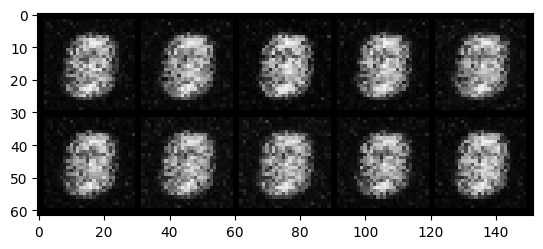

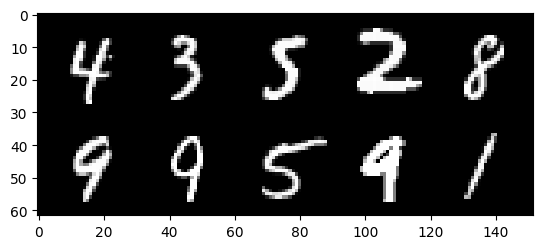

KeyboardInterrupt: ignored

In [99]:
## TRAINING LOOP ##

# Set the current step to 0
cur_step = 0

# Initialize the mean losses for the generator and discriminator
mean_generator_loss = 0
mean_discriminator_loss = 0
# Loop over all epochs
for epoch in range(n_epochs):
    # For each batch of real images and labels in the dataloader
    for real, _ in tqdm(dataloader):
        # Get the size of the current batch
        cur_batch_size = len(real)

        # Reshape the real images tensor and move it to the device
        real = real.view(cur_batch_size, -1).to(device)

        # Zero out the gradients from the discriminator optimizer
        disc_opt.zero_grad()

        # Compute the discriminator loss
        disc_loss = get_discriminator_loss(generator, discriminator, criterion, real, cur_batch_size, z_dim, device)

        # Compute the gradients for the discriminator parameters
        disc_loss.backward(retain_graph=True)

        # Update the discriminator parameters
        disc_opt.step()

        # Zero out the gradients from the generator optimizer
        gen_opt.zero_grad()

        # Compute the generator loss
        gen_loss = get_generator_loss(generator, discriminator, criterion, cur_batch_size, z_dim, device)

        # Compute the gradients for the generator parameters
        gen_loss.backward(retain_graph=True)

        # Update the generator parameters
        gen_opt.step()

        ### VISUALIZE IMAGES/LOSS ###
        # Update the mean losses to include the current batch's loss
        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        # If we've reached a display step, print the losses and show the generator's output
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")

            # Generate some fake images for visualization
            fake_noise = get_noise_tensor(cur_batch_size, z_dim, device=device)
            fake = generator(fake_noise)

            # Show the generated (fake) images and the real images for comparison
            show_tensor_images(fake)
            show_tensor_images(real)

            # Reset the mean losses for the next display step
            mean_generator_loss = 0
            mean_discriminator_loss = 0

        # Increment the step
        cur_step += 1